## PIP do Pennylane

In [10]:
%pip install pennylane

Note: you may need to restart the kernel to use updated packages.


## Código - Pré-processamento e clustering clássico

In [46]:
from sklearn.metrics.cluster import silhouette_score
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import rand_score, davies_bouldin_score
import pennylane as qml
from pennylane import numpy as np_qml
from pennylane.optimize import NesterovMomentumOptimizer,RotosolveOptimizer,GradientDescentOptimizer
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def normalize_data_transformY(X,y,range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(0, np.pi))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  y = 2*y -1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y, edgecolor="k")
    plt.show()
  return X_scaled, y

In [4]:
def cluster_classical(X,y, cluster_metric, unsupervised=True):
  # make a list of algorithms to use
  algorithms = [
      cluster.KMeans(2)
      , cluster.SpectralClustering(n_clusters=2,eigen_solver="arpack",affinity="nearest_neighbors")
      , AgglomerativeClustering(n_clusters=2)
      , cluster.DBSCAN()
  ]

  fig, axes = plt.subplots(1, len(algorithms)+1, figsize=(23, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

  # create a random cluster assignment for reference
  random_state = np.random.RandomState(seed=0)
  random_clusters = random_state.randint(low=0, high=2, size=len(X))

  # plot random assignment
  axes[0].scatter(X[:, 0], X[:, 1], c=random_clusters,
                  s=60)
  if unsupervised:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(X, random_clusters)))
  else:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(y, random_clusters)))

  for ax, algorithm in zip(axes[1:], algorithms):
      # plot the cluster assignments and cluster centers
      clusters = algorithm.fit_predict(X)
      ax.scatter(X[:, 0], X[:, 1], c=clusters,
                s=60)
      if unsupervised:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                              cluster_metric(X, clusters)))
      else:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                            cluster_metric(y, clusters)))

In [29]:
from sklearn.model_selection import KFold
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

def cluster_classical_kfold(X, y, cluster_metric, k=10, unsupervised=True):
    # Lista de algoritmos de clustering
    algorithms = [
        cluster.KMeans(2),
        cluster.SpectralClustering(n_clusters=2, eigen_solver="arpack", affinity="nearest_neighbors", n_neighbors=25),
        AgglomerativeClustering(n_clusters=2),
        cluster.DBSCAN()
    ]

    # Configuração do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lista para armazenar as métricas de cada algoritmo em cada fold
    scores = {algo.__class__.__name__: [] for algo in algorithms}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Configuração dos gráficos para cada fold
        fig, axes = plt.subplots(1, len(algorithms) + 1, figsize=(23, 3),
                                 subplot_kw={'xticks': (), 'yticks': ()})
        
        # Atribuição aleatória de clusters para referência
        random_state = np.random.RandomState(seed=fold_idx)  # Diferente por fold
        random_clusters = random_state.randint(low=0, high=2, size=len(X_val))

        # Plotagem da atribuição aleatória
        axes[0].scatter(X_val[:, 0], X_val[:, 1], c=random_clusters, s=60)
        if unsupervised:
            axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
                                                                      cluster_metric(X_val, random_clusters)))
        else:
            axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
                                                                      cluster_metric(y_val, random_clusters)))

        # Aplicar cada algoritmo de clustering
        for ax, algorithm in zip(axes[1:], algorithms):
            clusters = algorithm.fit_predict(X_train)  # Treinamento com X_train

            # Prever clusters no conjunto de validação
            val_clusters = algorithm.fit_predict(X_val) if hasattr(algorithm, 'fit_predict') else algorithm.fit(X_val).predict(X_val)

            # Plotagem dos clusters
            ax.scatter(X_val[:, 0], X_val[:, 1], c=val_clusters, s=60)
            score = cluster_metric(X_val, val_clusters) if unsupervised else cluster_metric(y_val, val_clusters)
            scores[algorithm.__class__.__name__].append(score)
            
            ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__, score))
        
        plt.suptitle(f"Fold {fold_idx + 1}")
        plt.show()

       # Plotar os scores para cada algoritmo ao longo dos folds
    plt.figure(figsize=(10, 6))
    for algo_name, algo_scores in scores.items():
        plt.plot(range(1, k + 1), algo_scores, marker='o', label=algo_name)
    
    plt.xlabel("Número do Fold")
    plt.ylabel("Score de Clustering")
    plt.title("Scores de Clustering por Fold para Cada Algoritmo")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Média das métricas por algoritmo após k-fold cross-validation
    avg_scores = {algo: np.mean(scores[algo]) for algo in scores}
    print("Médias das métricas após k-fold cross-validation:", avg_scores)


In [14]:
def print_decision_region(X,y, qnode, x_max, y_max, weights, bias):

    y = np.array(y).reshape((len(y),1))

    plt.figure()
    cm = plt.cm.RdBu

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    # preprocess grid points like data inputs above
    #padding = 0.3 * np.ones((len(X_grid), 1))
    #X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
    #normalization = np.sqrt(np.sum(X_grid ** 2, -1))
    #X_grid = (X_grid.T / normalization).T  # normalize each input
    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [variational_classifier(qnode,weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    # plot data
    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == 1],
        X[:, 1].reshape((len(X),1))[y == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )

    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == -1],
        X[:, 1].reshape((len(X),1))[y == -1],
        c="r",
        marker="o",
        edgecolors="k",
        label="class -1 train",
    )


    plt.legend()
    plt.show()

## Código de definições quânticas

In [15]:
dev = qml.device("lightning.gpu", wires=2)
def statepreparation(x):
    #qml.AmplitudeEmbedding(features=x, wires=range(2))
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def layer1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])


def layer2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

def layer3(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer4(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer5(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[6, 0], W[6, 1], W[6, 2], wires=0)
    qml.Rot(W[7, 0], W[7, 1], W[7, 2], wires=1)
    qml.CNOT(wires=[1, 0])


@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X, inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer1(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type2(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer2(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type3(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer3(W)

    return qml.expval(qml.PauliZ(wires=0))


@qml.qnode(dev, interface="autograd")
def circuit_type4(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer4(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type5(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer5(W)

    return qml.expval(qml.PauliZ(wires=0))

def variational_classifier(qnode,weights, bias, X,inputInLayer=False):
    return qnode(weights, X,inputInLayer) + bias

def metric_square_loss_silhouette(features, predictions, labels):
  return np_qml.float16(1 - np_qml.float16(silhouette_score(features, predictions)))

def metric_square_loss_rand_score(features, predictions, labels):
  return np_qml.float16(1-rand_score(labels, predictions))

def metric_square_loss_davies_bouldin_score(features, predictions, labels):
  return np_qml.float16(1 - np_qml.float16(davies_bouldin_score(features, predictions)))

def square_loss(metric, features, predictions, labels):
    predictions = [float(i) for i in predictions]
    if len(np.unique(predictions))==1:
        return np_qml.float16(1)
    else:
        return metric(features, predictions, labels)

def cost(weights,bias, qnode,metric,features, labels,inputInLayer):
    predictions = [variational_classifier(qnode,weights, bias, xi,inputInLayer) for xi in features]
    predictions = np_qml.sign(predictions)
    return square_loss(metric,features, predictions,labels)

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

## Código do treinamento

In [16]:
def train(qnode,X,y,num_qubits,num_params_w_lines, num_params_w_columns,metric,metricValidation,num_layers,weight_init_max,optimizer, dic_optimizer, seed,inputInLayer=False,iterations=100):
    np_qml.random.seed(seed)

    #num_qubits = 2
    #num_layers = 2
    #num_train=len(X)

    weights_init = (weight_init_max) * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)
    bias_init = np_qml.array(0.0, requires_grad=True)

    batch_size = len(X)

    drawer = qml.draw(circuit)
    print(drawer(weights_init, X))

    #num_steps_spsa = 10
    #opt = qml.SPSAOptimizer(maxiter=num_steps_spsa)
    opt = optimizer(**dic_optimizer)

    # train the variational classifier
    weights = weights_init
    bias = bias_init

    best_weights = weights
    best_bias = bias
    best_cost = 99999

    for it in range(iterations):

        # Update the weights by one optimizer step
        batch_index = np_qml.random.randint(0, batch_size, (batch_size,))
        X_train_batch = X[batch_index]
        Y_train_batch = y[batch_index]

        #TREINANDO
        arguments = [weights, bias, qnode,metric,X_train_batch, Y_train_batch,inputInLayer]
        weights, bias, _, _,_,_,_ = opt.step(cost, *arguments)

        # Compute predictions on train and validation set
        predictions_val = [np_qml.sign(variational_classifier(qnode,weights, bias, xi)) for xi in X]

        # Compute accuracy on train and validation set
        acc_val = metricValidation(X,predictions_val,y)

        iteration_cost = cost(weights, bias, qnode,metric,X, y,inputInLayer)
        if iteration_cost < best_cost:
          best_weights, best_bias, best_cost = weights, bias, iteration_cost

        print(
            "Iter: {:5d} | Cost ({}): {:0.7f} | Acc validation ({}): {:0.7f} "
            "".format(it + 1, metric.__name__,iteration_cost, metricValidation.__name__,acc_val)
        )
        #print("W",weights,"B",bias)
    return best_weights, best_bias

In [70]:
from sklearn.model_selection import KFold
import numpy as np

def train_kfold(qnode, X, y, num_qubits, num_params_w_lines, num_params_w_columns, metric, metricValidation, 
                num_layers, weight_init_max, optimizer, dic_optimizer, seed, inputInLayer=False, iterations=100, k=10):
    np_qml.random.seed(seed)

    # Inicialização do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    
    fold_scores = []
    
    # Loop pelos folds do k-fold
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        print(f"Treinando Fold {fold_idx + 1}/{k}")

        # Inicialização do otimizador
        opt = optimizer(**dic_optimizer)
        

        if isinstance(opt, qml.RotosolveOptimizer):
            # Configuração específica para RotosolveOptimizer
            weights_init = np.random.uniform(-weight_init_max, weight_init_max, num_layers * num_params_w_lines * num_params_w_columns)
            bias_init = np.random.uniform(-weight_init_max, weight_init_max, size=(1,))

            # Para RotosolveOptimizer
            weights_init = np_qml.array(weights_init, requires_grad=True)  # Garante que weights são treináveis
            bias_init = np_qml.array(bias_init, requires_grad=True)  # Garante que bias é treinável
        else:
            # Configuração padrão para os outros otimizadores
            weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)
            bias_init = np_qml.array(0.0, requires_grad=True)


        


        # if isinstance(opt, qml.RotosolveOptimizer):
        #     # Inicialização específica para o RotosolveOptimizer
        #     weights_init = np.random.uniform(-weight_init_max, weight_init_max, num_layers * num_params_w_lines * num_params_w_columns)
        # else:
        #     # Inicialização para os outros otimizadores
        #     weights_init = (weight_init_max) * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)


        # # Inicialização dos pesos e bias para cada fold
        # weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)

        # bias_init = np_qml.array(0.0, requires_grad=True)
        weights = weights_init
        bias = bias_init

        best_weights = weights
        best_bias = bias
        best_cost = float('inf')

        # Treinamento para o número de iterações desejado
        for it in range(iterations):
            # Mini-batch aleatório
            batch_index = np_qml.random.randint(0, len(X_train), len(X_train))
            X_train_batch = X_train[batch_index]
            Y_train_batch = y_train[batch_index]

            # Treinamento do modelo no batch
            arguments = [weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer]
            weights, bias, _, _, _, _, _ = opt.step(cost, *arguments)

            # Predição e cálculo da métrica de validação
            predictions_val = [np_qml.sign(variational_classifier(qnode, weights, bias, xi)) for xi in X_val]
            acc_val = metricValidation(X_val, predictions_val, y_val)

            iteration_cost = cost(weights, bias, qnode, metric, X_train, y_train, inputInLayer)
            if iteration_cost < best_cost:
                best_weights, best_bias, best_cost = weights, bias, iteration_cost

            print(
                "Iter: {:5d} | Cost ({}): {:0.7f} | Acc validation ({}): {:0.7f}"
                .format(it + 1, metric.__name__, iteration_cost, metricValidation.__name__, acc_val)
            )

        # Armazenar a acurácia de validação do fold atual
        fold_scores.append(acc_val)

    # Resultado final: média das acurácias nos folds
    avg_score = np.mean(fold_scores)
    print(f"Score médio de validação após {k}-fold: {avg_score:.4f}")

    return best_weights, best_bias, avg_score


## Base de dados - 2 bolhas / 2 classes

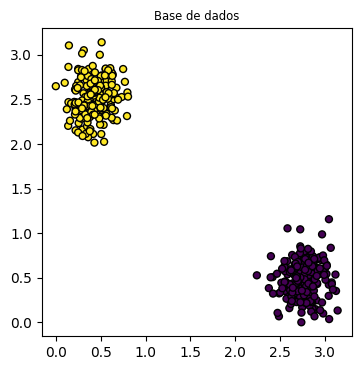

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


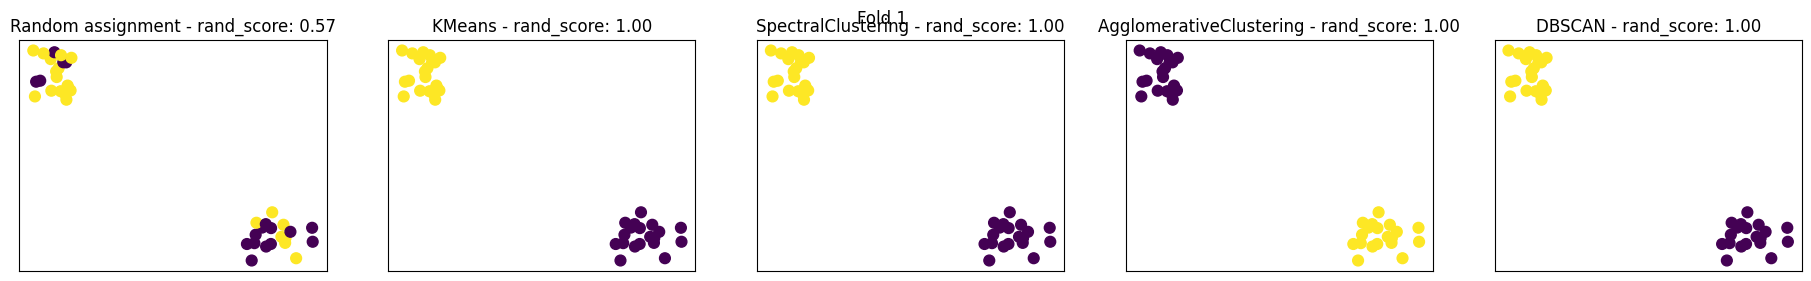

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


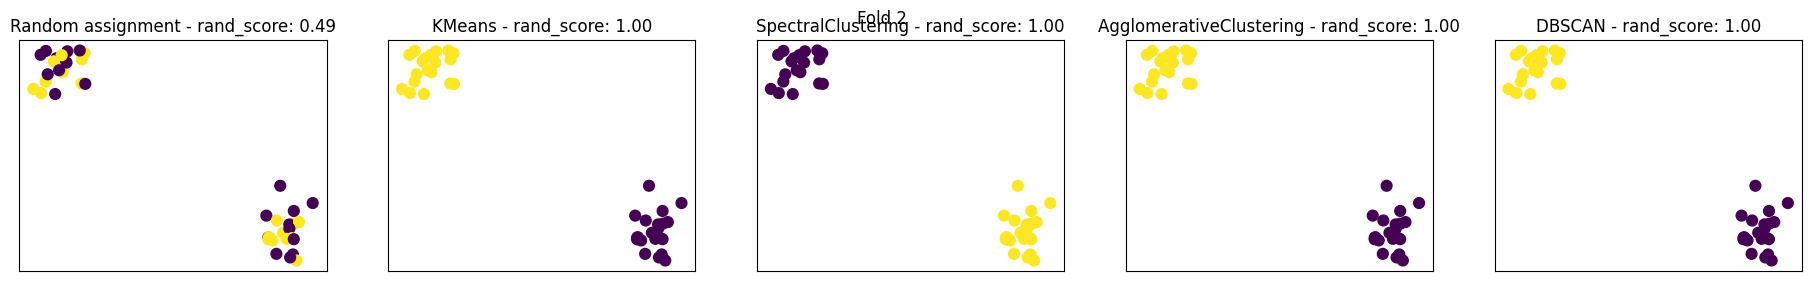

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


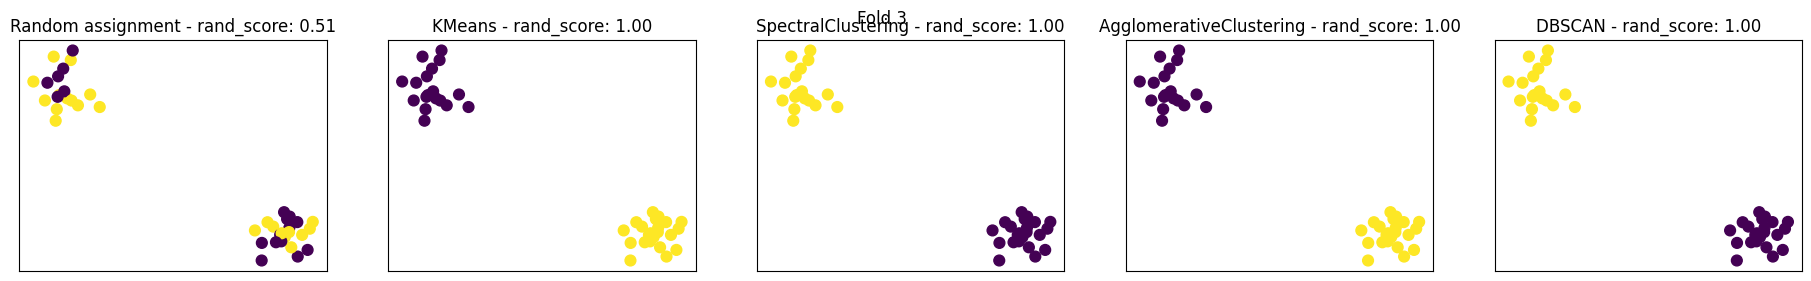

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


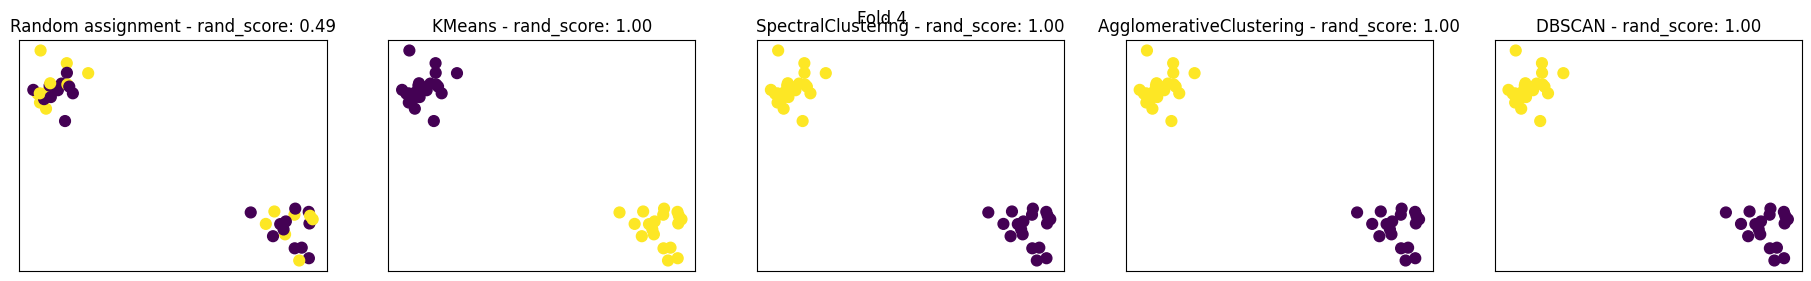

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


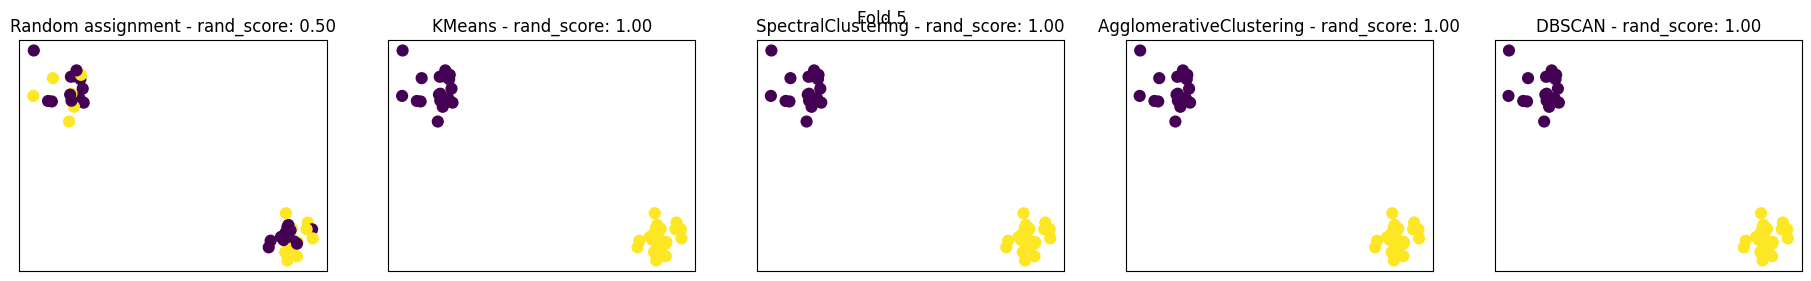

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


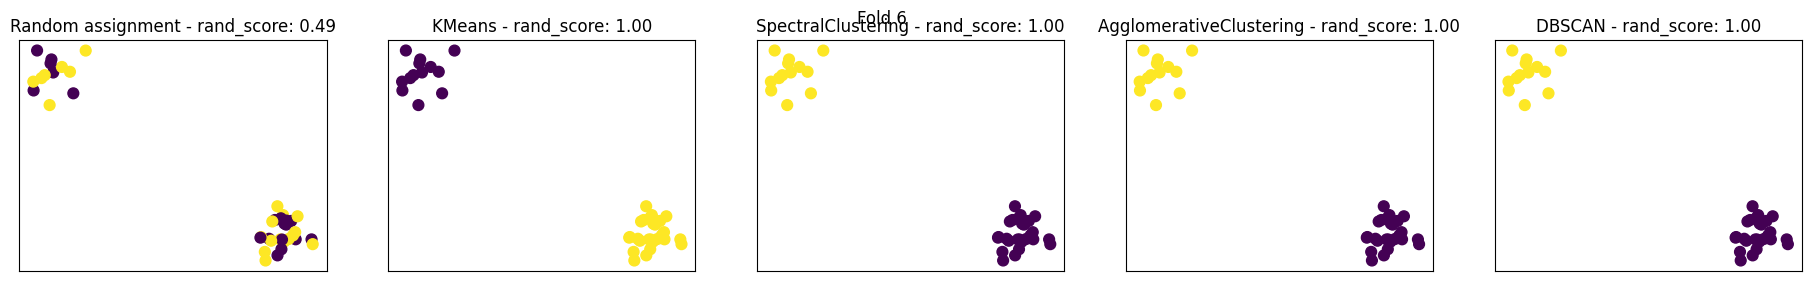

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


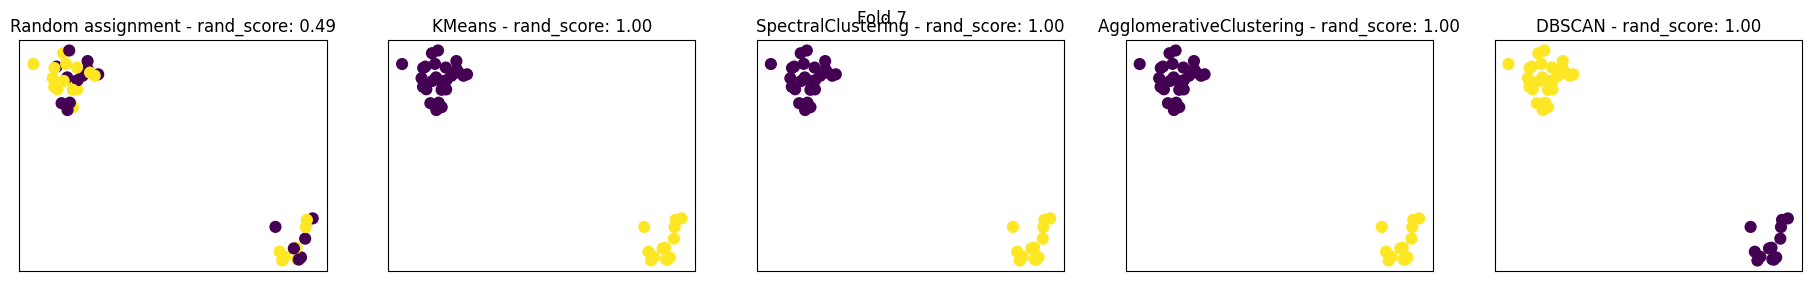

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


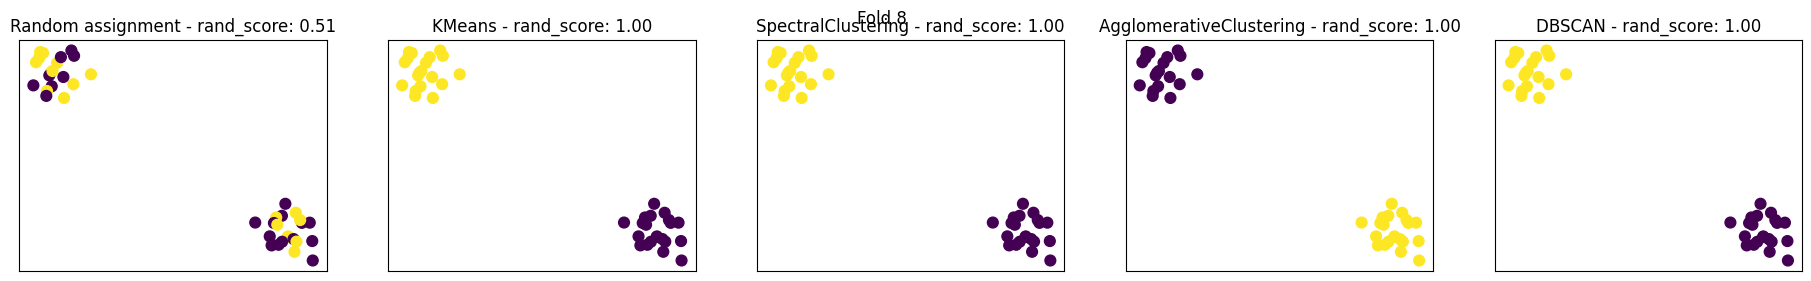

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


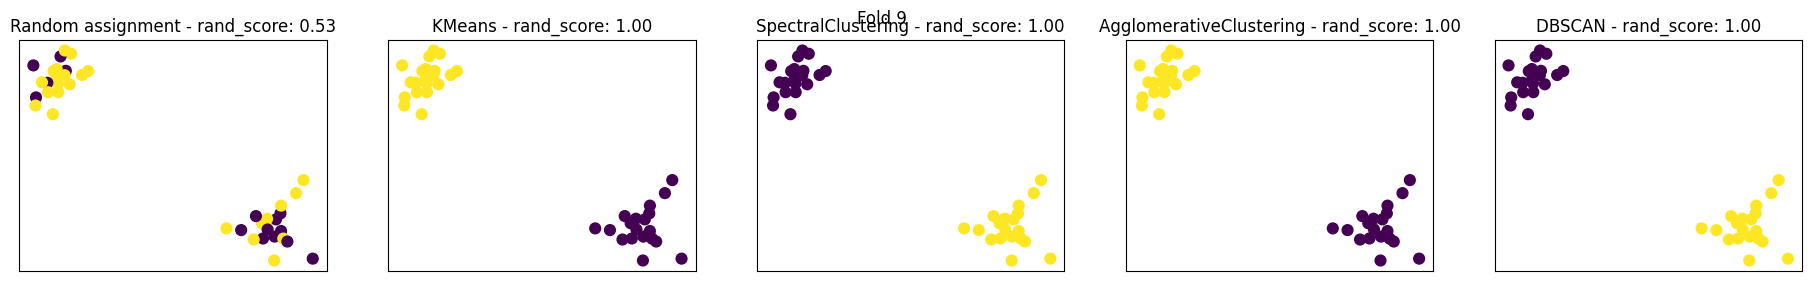

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


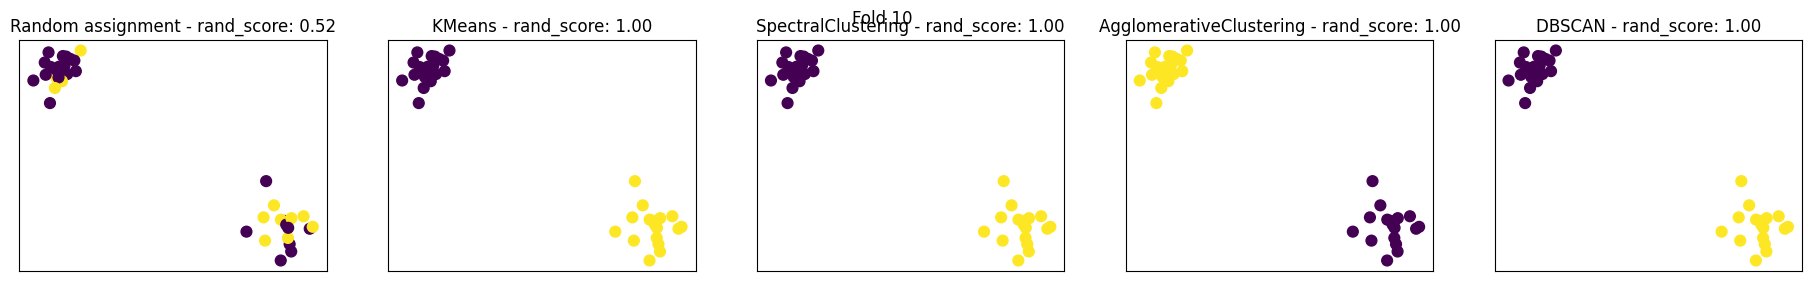

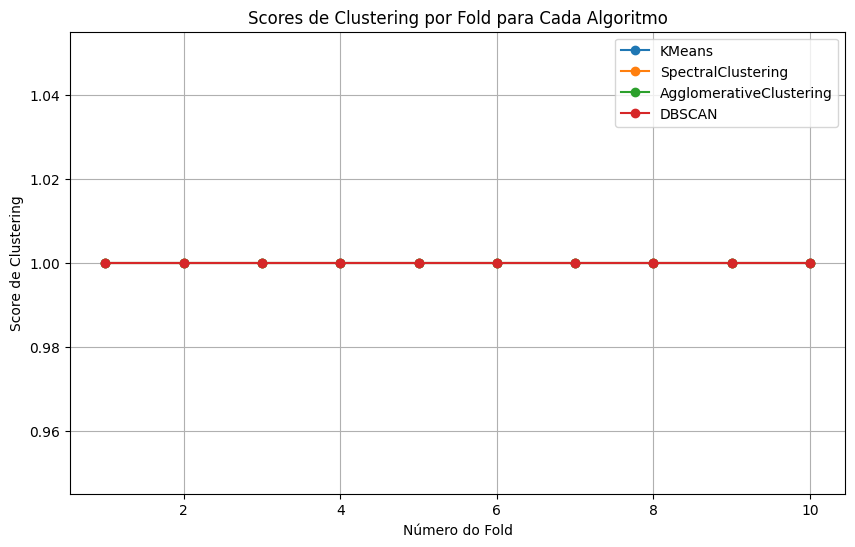

Médias das métricas após k-fold cross-validation: {'KMeans': 1.0, 'SpectralClustering': 1.0, 'AgglomerativeClustering': 1.0, 'DBSCAN': 1.0}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


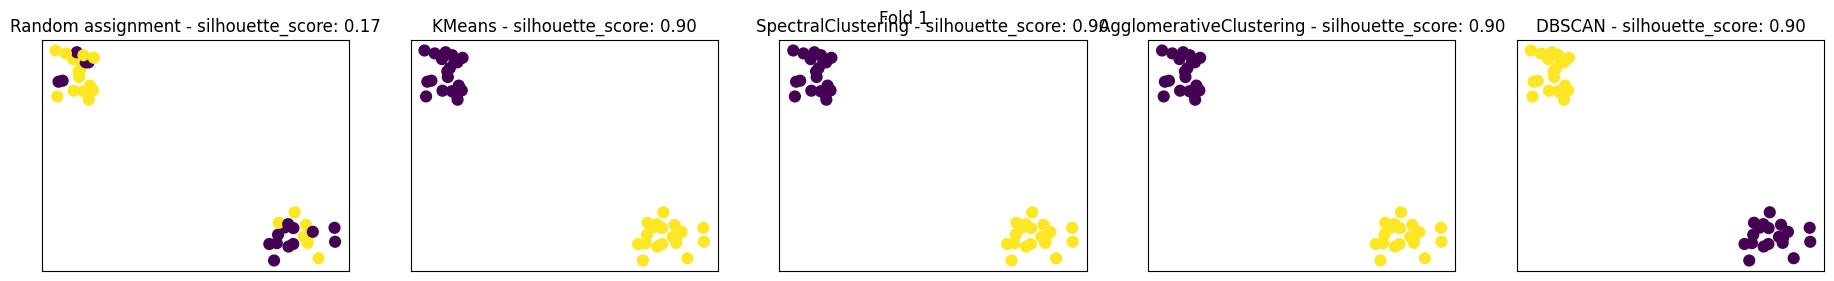

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


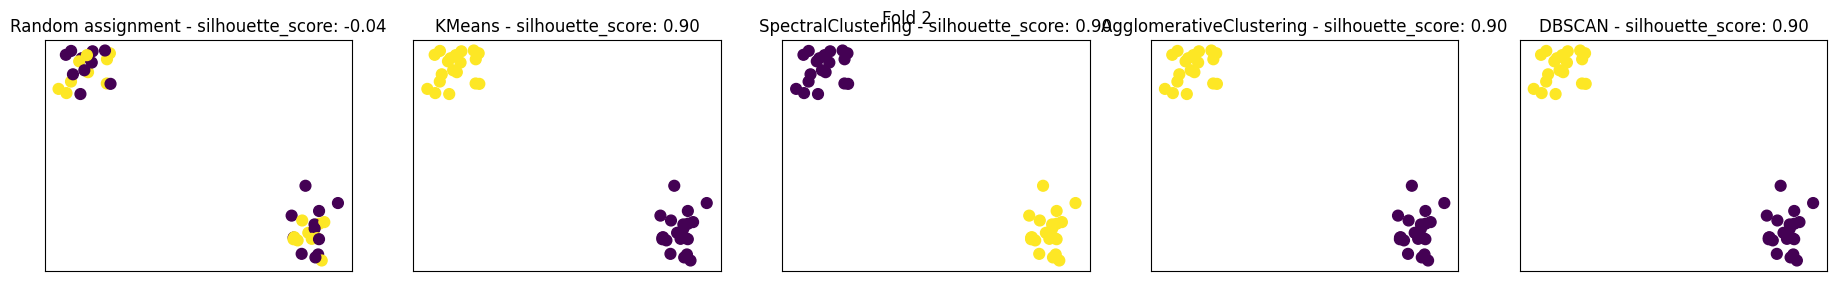

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


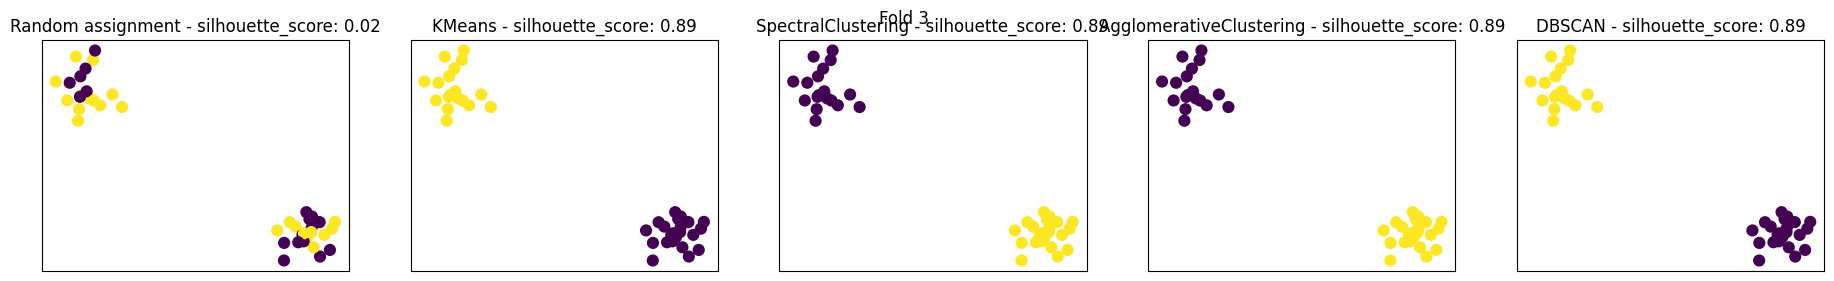

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


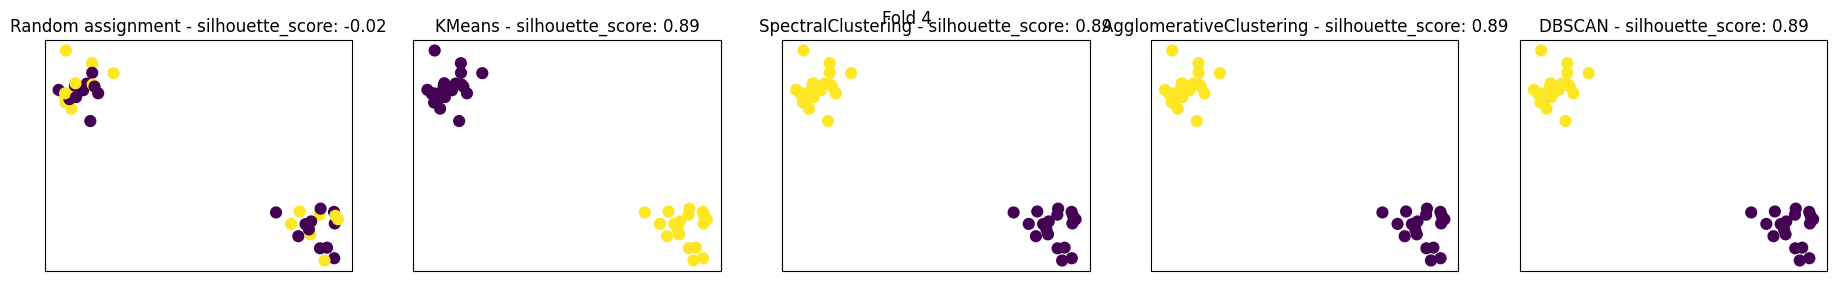

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


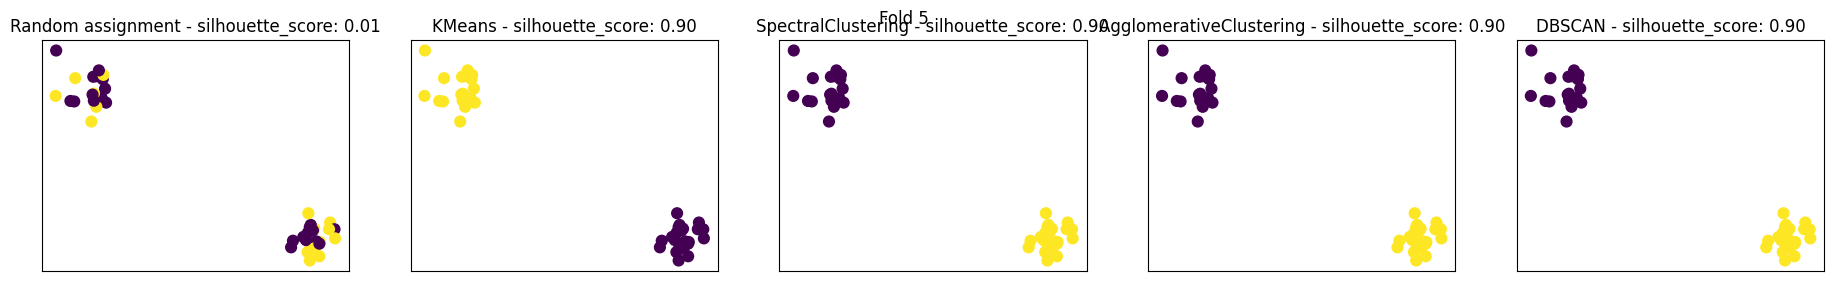

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


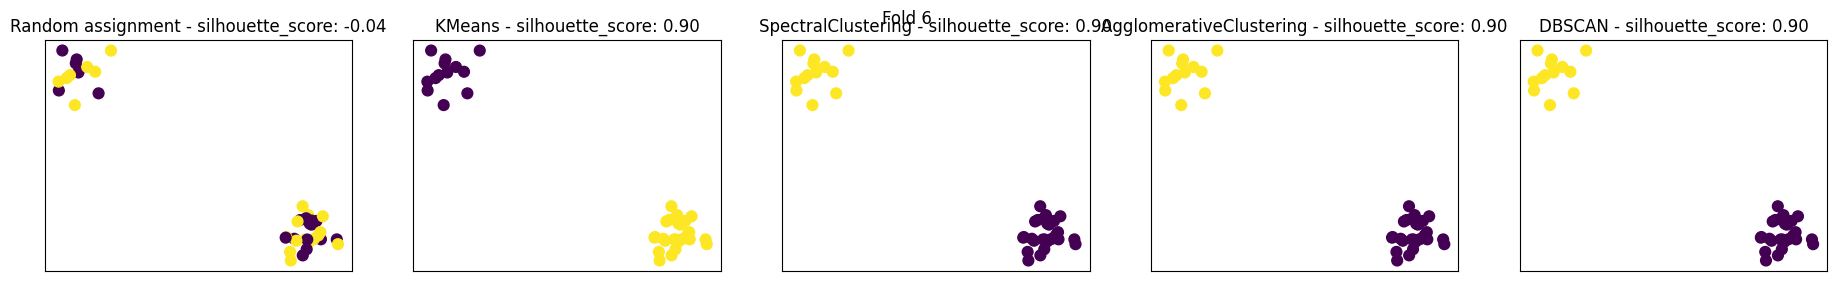

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


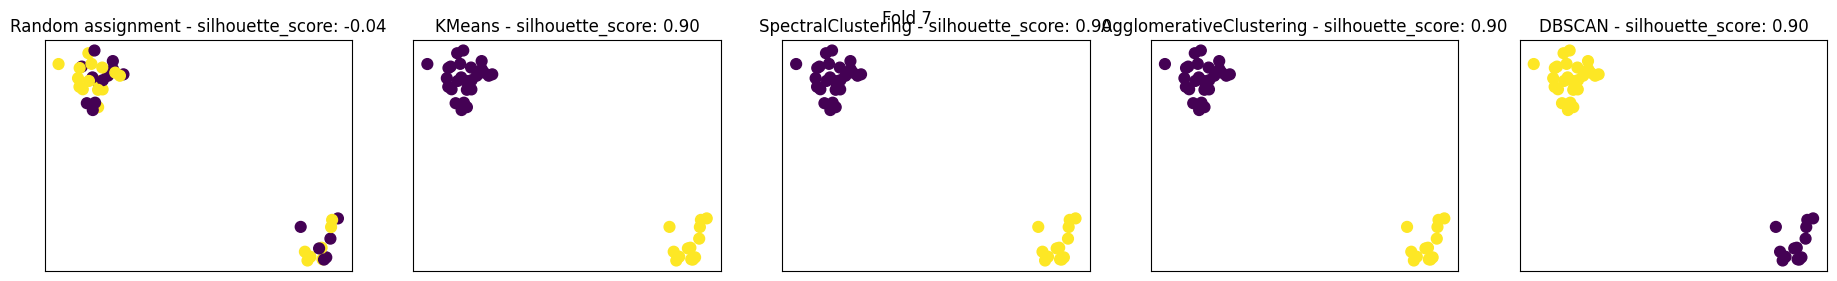

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


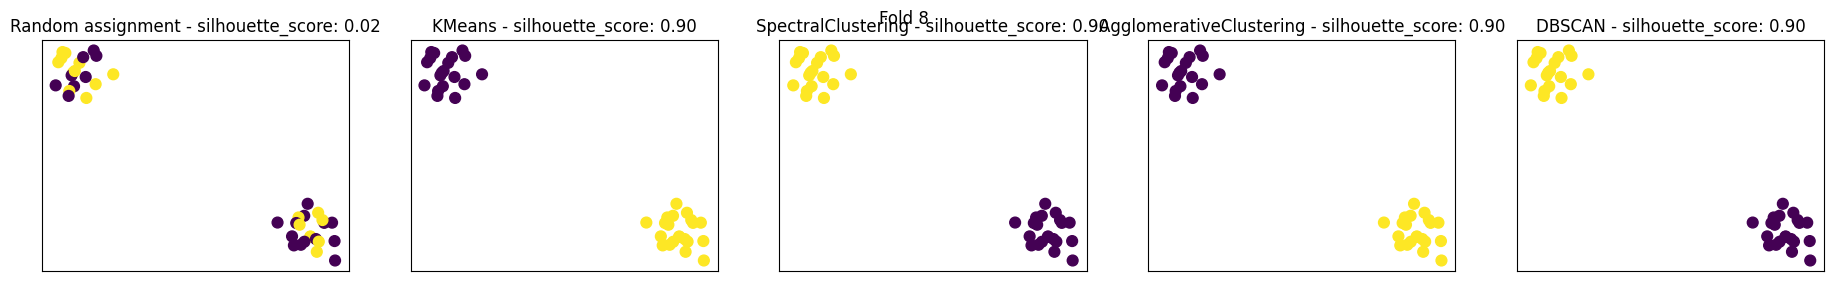

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


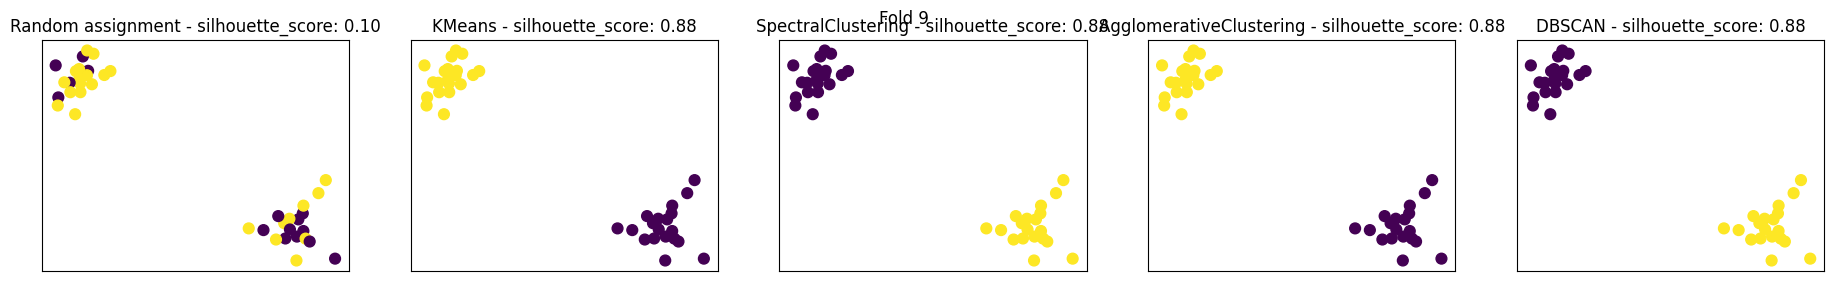

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


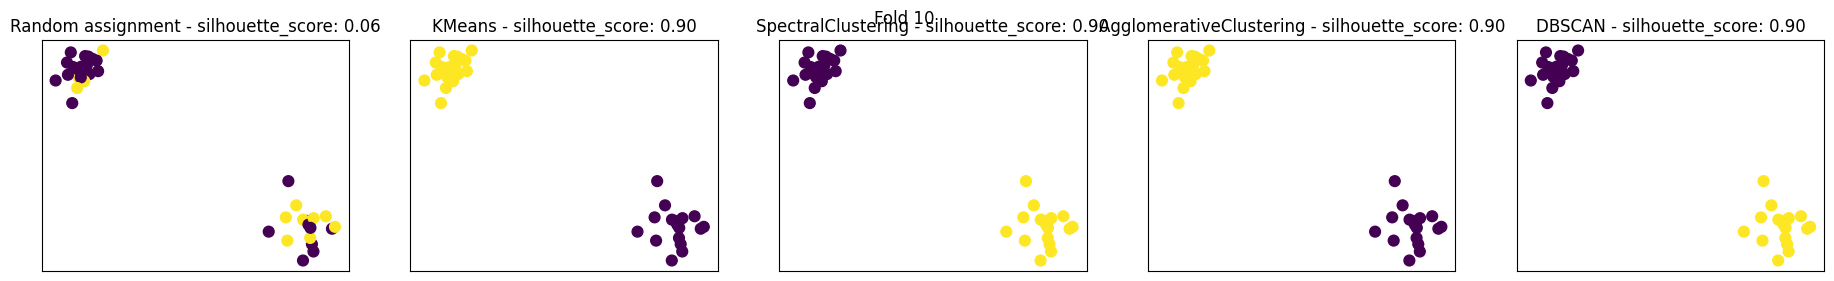

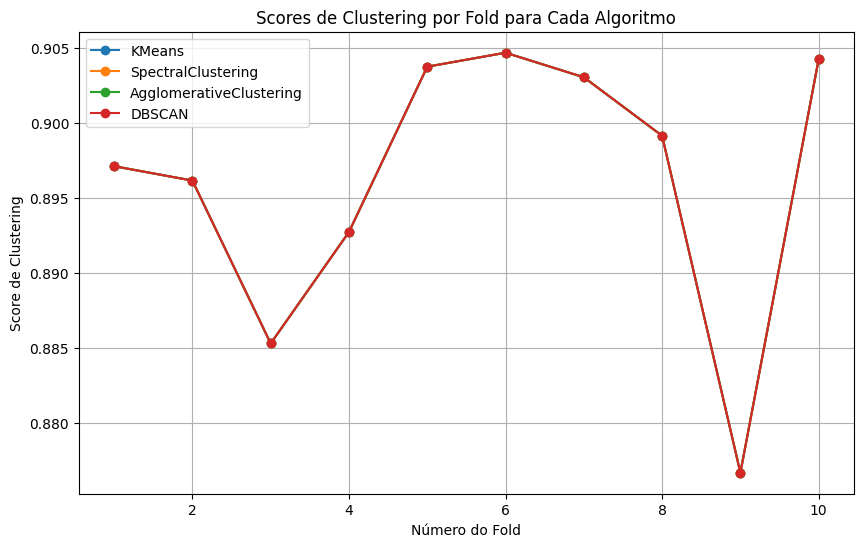

Médias das métricas após k-fold cross-validation: {'KMeans': 0.8962758711051835, 'SpectralClustering': 0.8962758711051835, 'AgglomerativeClustering': 0.8962758711051835, 'DBSCAN': 0.8962758711051835}


In [44]:
X, y = make_blobs(n_samples=400, centers=2, random_state=29)

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical_kfold(X,y,cluster_metric=silhouette_score, unsupervised=True)

In [ ]:
# Definindo as combinações de otimizadores e circuitos a serem testados
optimizers = {
    'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
    # 'RotosolveOptimizer': RotosolveOptimizer,
    'GradientDescentOptimizer': GradientDescentOptimizer,
    'SPSAOptimizer': qml.SPSAOptimizer
}

circuits = [(circuit_type1, 2), (circuit_type2, 4), (circuit_type3, 6), (circuit_type4, 6), (circuit_type5, 8)]

# Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
    'RotosolveOptimizer': {},
    'GradientDescentOptimizer': {'stepsize': 0.1},
    'SPSAOptimizer': {'maxiter': 10}
}

# Parâmetros do experimento
num_layers_options = [2, 4]  # Escolher o número de camadas para o experimento

# Armazenamento dos melhores resultados
best_results = {
    'optimizer': None,
    'circuit_type': None,
    'num_layers': None,
    'avg_score': float('inf'),
    'weights': None,
    'bias': None
}

# Loop para experimentar combinações
for circuit_fn, num_params_w_lines in circuits:
    for optimizer_name, optimizer_class in optimizers.items():
        for num_layers in num_layers_options:
            print(f"{circuit_fn} - {optimizer_name} - {num_layers}")
            # Instanciar o circuito e o QNode
            circuit = circuit_fn
            qnode = qml.QNode(circuit, dev, interface="torch")

            # # Inicializar o otimizador com seus parâmetros
            # optimizer = optimizer_class(**optimizer_params.get(optimizer_name, {}))

            # Treinamento com k-fold
            weights, bias, avg_score = train_kfold(
                qnode,
                X,
                y,
                num_qubits=2,
                num_params_w_lines=num_params_w_lines,
                num_params_w_columns=3,
                metric=metric_square_loss_silhouette,
                metricValidation=metric_square_loss_rand_score,
                num_layers=num_layers,
                weight_init_max=np.pi,
                optimizer=optimizer_class,
                dic_optimizer=optimizer_params[optimizer_name],
                seed=1,
                inputInLayer=False,
                iterations=1
            )

            # Armazenar os melhores resultados
            if avg_score < best_results['avg_score']:
                best_results.update({
                    'optimizer': optimizer_name,
                    'circuit_type': circuit_fn.__name__,
                    'num_layers': num_layers,
                    'avg_score': avg_score,
                    'weights': weights,
                    'bias': bias,
                    'qnode': qnode
                })

# Exibir os melhores parâmetros e resultados
print("Melhores Resultados:")
print(f"Otimizer: {best_results['optimizer']}")
print(f"Circuit Type: {best_results['circuit_type']}")
print(f"Num Layers: {best_results['num_layers']}")
print(f"Avg Score: {best_results['avg_score']}")

# Visualizar a decisão do melhor modelo
print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])


<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 2
Treinando Fold 1/10


### Treinando

In [38]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias, avg_score = train_kfold(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1245117 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1030273 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 4/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1015625 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 5/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 6/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 7/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2026367 | Acc validation (metric_square_loss_rand_score): 0.0499878
Treina

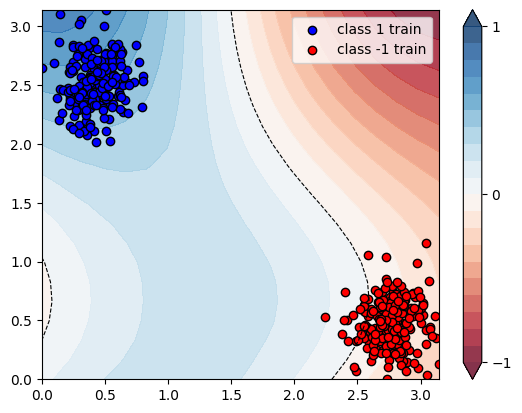

In [39]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [41]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias, avg_score = train_kfold(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6933594 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1093750 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0000000 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 4/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6699219 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 5/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4833984 | Acc validation (metric_square_loss_rand_score): 0.4665527
Treinando Fold 6/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.1230469 | Acc validation (metric_square_loss_rand_score): 0.3281250
Treinando Fold 7/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2700195 | Acc validation (metric_square_loss_rand_score): 0.1423340
Treina

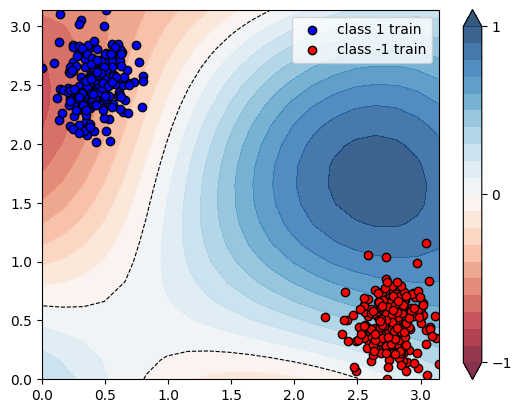

In [42]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

## Base de dados - 4 bolhas / 2 classes

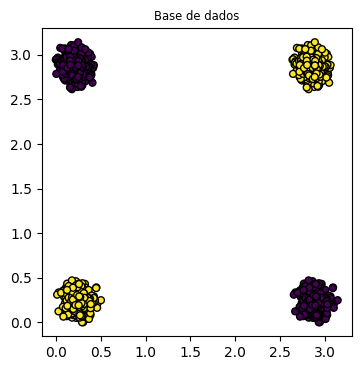

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


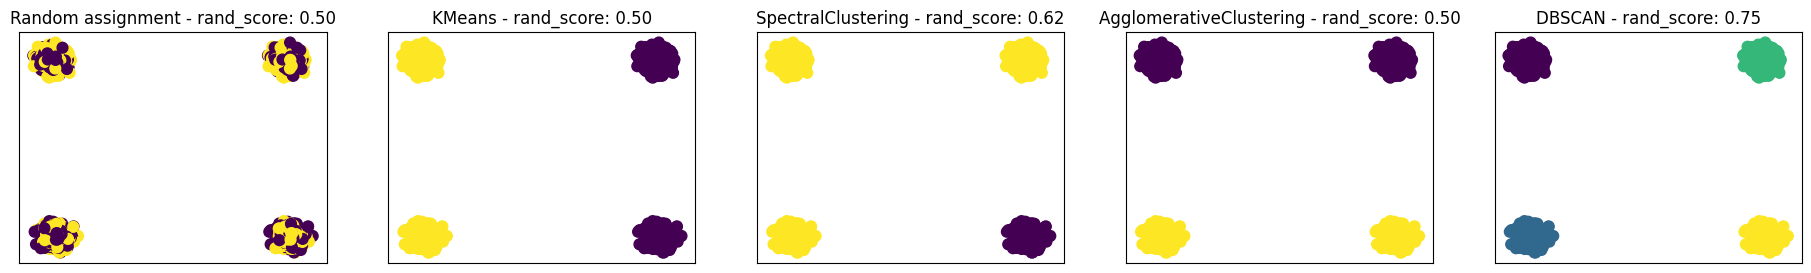

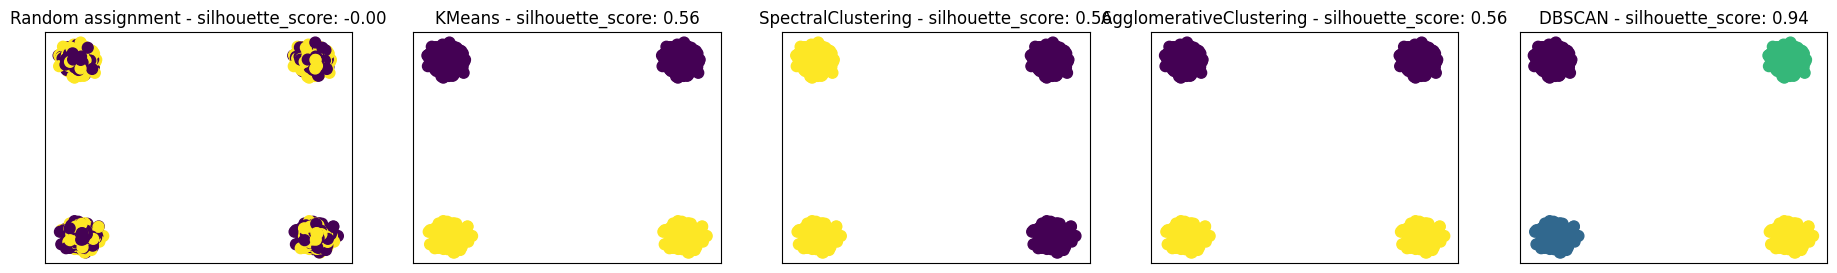

In [43]:
num_classes = 2
feature_size = 2
X1, y1 = make_blobs(random_state=0,n_features=feature_size, centers=num_classes,n_samples=1000, cluster_std=0.15)
X2 = X1.copy()
a1 = np.where(X2[:,0] >1.5, X2[:,0]-1, X2[:,0])
a2 = np.where(X2[:,1] >3, X2[:,1]+1, X2[:,1])
X2 = np.array(np.concatenate((np.matrix(a1).T,np.matrix(a2).T),axis=1))
X1 = X2.copy()
X1[:,0] = X1[:,0]+5
y2 = (y1.copy()+1)%2
X3 = np.concatenate((X2,X1),axis=0)
y3 = np.concatenate((y1,y2),axis=0)

X = X3
y = y3

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical(X,y,cluster_metric=silhouette_score, unsupervised=True)


In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi, 
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=50)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)